In [1]:
# MODEL ONLY
# Here, Z is converted into solar units:
#     Z_sim is in mass fraction units
#     Z_arr = Z_sim/0.02
#     kappa = 1000*m_p*Z_arr  --> in n_LW & n_LW_ss
#     denominator = CC * Z_arr * n_H  --> in X_H2
#     n_CO = 1e-4*n_H*X_CO*Z_arr
#     5kpc
# Just taking the 2 --> 1 transition
# Or up_level = 2; low_level = 1
# i.e., i = 1; j = 0
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

In [2]:
%matplotlib inline

#import sys
import numpy as np
#np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
import matplotlib.colors as cm
import pynbody
from michaels_functions import center_and_r_vir, remove_bulk_velocity
from matplotlib.colors import LogNorm
from matplotlib.pyplot import figure

In [3]:
path = "bulk1/data_2/hydro_59/output/"
data = pynbody.load(path + "output_00050")
aexp = data.properties['a']
data.physical_units()
r_vir = center_and_r_vir(data, aexp, path)
remove_bulk_velocity(data)
r_e = 0.1 * r_vir
sph_5 = pynbody.filt.Sphere(radius = '5.0 kpc') # %(r_e*1.4))
region = data[sph_5]
rho = region.gas["rho"].in_units("m_p cm**-3")
f = open(data.filename + "/info_"+data.filename[-5:]+".txt","r")
lines = f.readlines()
f.close()
for line in lines:
    if line[0:13]=="unit_l      =":
        print line[:-1]
        unit_l = float(line[14:-1])
    if line[0:13]=="unit_d      =":
        print line[:-1]
        unit_d = float(line[14:-1])
    if line[0:13]=="unit_t      =":
        print line[:-1]
        unit_t = float(line[14:-1])
    if line[0:13]=="omega_b     =":
        print line[:-1]
        omega_b = float(line[14:-1])

('shifting on Stars:', SimArray([ 0.00308878, -0.03302971, -0.04676732], 'kpc'))
('virial radius:', SimArray(152.40432611, 'kpc'))
omega_b     =  0.450000017881393E-01
unit_l      =  0.682025380323961E+26
unit_d      =  0.123367583719985E-28
unit_t      =  0.163687521954501E+18


In [4]:
m_p = pynbody.array.SimArray(1.672621777e-24, "g")
K_b = pynbody.array.SimArray(1.38064852e-16, "cm**2 g s**-2 K**-1")
G = pynbody.array.SimArray(6.67259e-8, "cm**3 g**-1 s**-2")
T_mean = pynbody.array.SimArray(10., "K")
K_b_ev = pynbody.array.SimArray(8.617e-5, "eV K**-1")
c_si = pynbody.array.SimArray(2.99792458e5, "km s**-1")
c_cgs = pynbody.array.SimArray(2.99792458e10, "cm s**-1")
h_ev = pynbody.array.SimArray(4.13566770e-15, "eV s")
mH_cgs = pynbody.array.SimArray(1.6737236e-24, 'g')  # hydrogen mass
T_bg = pynbody.array.SimArray(2.73, "K")
eV = pynbody.array.SimArray(6.241509e18, "J")
L_sun = pynbody.array.SimArray(2.43418864387146974e+45, "eV s**-1")
cell_width = pynbody.array.SimArray(region.gas["smooth"]*3.086e+21, "cm")

In [5]:
n_H_1_arr = pynbody.array.SimArray(np.load('outputs/sub_grid_test/n_H.npy'), "cm**-3")
n_H_arr = pynbody.array.SimArray(np.load('outputs/sub_grid_test/n_H_prime.npy'), "cm**-3")
n_H2_arr = pynbody.array.SimArray(np.load('outputs/sub_grid_test/n_H2.npy'), "cm**-3")
X_H2_arr = pynbody.array.SimArray(np.load('outputs/sub_grid_test/X_H2.npy'), "1")
n_LW_arr = np.load('outputs/sub_grid_test/n_LW.npy')
n_LW_ss_arr = np.load('outputs/sub_grid_test/n_LW_ss.npy')
X_H2_ss_arr = pynbody.array.SimArray(np.load('outputs/sub_grid_test/X_H2_ss.npy'), "1")
n_H2_ss_arr = pynbody.array.SimArray(np.load('outputs/sub_grid_test/n_H2_ss.npy'), "cm**-3")
X_CO_arr = pynbody.array.SimArray(np.load('outputs/sub_grid_test/X_CO.npy'), "1")
n_CO_arr = pynbody.array.SimArray(np.load('outputs/sub_grid_test/n_CO.npy'), "cm**-3")
pdf_1_arr = np.load('outputs/sub_grid_test/pdf.npy')
pdf_arr = np.load('outputs/sub_grid_test/pdf_prime.npy')
lambda_jeans_arr = pynbody.array.SimArray(np.load('outputs/sub_grid_test/lambda_jeans.npy'), "cm")

In [6]:
def get_filename(species):
    # filename is already given
    if (species[-4:] == '.dat') or (species[-4:] == '.txt'):
        return species
    # molecule is chosen
    THIS_FOLDER = os.path.dirname(os.path.abspath(__file__))
    database = os.path.join(THIS_FOLDER, 'LAMDA')
    if species == 'HCO+':
        filename = os.path.join(database, 'HCO+.dat')
    elif species == 'H13CO+':
        filename = os.path.join(database, 'H13CO+.dat')
    elif species == 'N2H+':
        filename = os.path.join(database, 'N2H+.dat')
    elif species == 'SiO':
        filename = os.path.join(database, 'SiO.dat')
    elif species == 'HNC':
        filename = os.path.join(database, 'HNC.dat')
    elif species == 'HCN':
        filename = os.path.join(database, 'HCN.dat')
    elif species == 'CO':
        filename = os.path.join(database, 'CO.dat')
    else:
        print('Unknow species. Chose from HCO+, H13CO+, N2H+, SiO, HNC, HCN, CO')
        print('or provide a LAMDA datafile.')
        exit()

    return filename

def read_file(species, c_cgs, h_ev, K_b_ev):
    filename = get_filename(species)
    f = open(filename, 'r')

    f.readline()
    species = f.readline()

    f.readline()
    mu = float(f.readline())  # molecular weight

    f.readline()
    num_lvls = int(f.readline())  # number of energy levels

    # read energy levels: energy E, statistical weight g
    f.readline()
    E = []
    g = []
    for l in range(num_lvls):
        words = f.readline().split()
        E.append(float(words[1]) *c_cgs*h_ev) # cm^-1 -> eV
        g.append(float(words[2]))

    f.readline()
    num_trans = int(f.readline())  # number of radiative transistions

    # read transistions: upper lvl, lower lvl, A-coefficient, frequency
    f.readline()
    A = np.zeros((num_lvls, num_lvls))
    freq = np.zeros((num_lvls, num_lvls))
    for t in range(num_trans):
        words = f.readline().split()
        up = int(words[1]) - 1
        low = int(words[2]) - 1
        if up-low==1:
            A[up][low] = float(words[3])  # s^-1
            freq[up][low] = float(words[4]) * 1e9  # GHz -> Hz
            #freq[low][up] = freq[up][low] #un-comment this only if low->up transitions are also allowed

    # compute B-coefficient via Einstein relations
    # Bij = coeff for stimulated emission, Bji = coeff for extinction (j<i)
    B = np.zeros((num_lvls, num_lvls))
    for i in range(0, num_lvls):
        for j in range(0, i):
            if A[i][j] != 0:
                B[i][j] = A[i][j] * (c_cgs**2) / (2*h_ev * (freq[i][j])**3) # cm2/(eV*s)
                B[j][i] = B[i][j] * g[i]/g[j]

    # number of collision partners in the data file
    f.readline()
    num_partners = int(f.readline())

    C_all = []
    temps_all = []
    for partner in range(num_partners):
        # reference
        f.readline()
        line = f.readline()

        # number of collisional transitions
        f.readline()
        num_coll = int(f.readline())

        # number of temperatures in the table
        f.readline()
        num_temps = int(f.readline())

        # read the temperature values
        f.readline()
        words = f.readline().split()
        temps = np.zeros(num_temps)
        for t in range(num_temps):
            temps[t] = float(words[t])
            temps_all.append(temps)  # K

        # read collision coeff data: upper lvl, lower lvl, C-coefficient for each temp
        C = np.zeros((num_temps, num_lvls, num_lvls))
        f.readline()
        for col in range(num_coll):
            words = f.readline().split()
            i = int(words[1]) - 1
            j = int(words[2]) - 1
            for t in range(num_temps):
                C[t][i][j] = float(words[3+t]) #* 1.e-6 # cm3/s -> m3/s

        # calculate the inverse coefficient via LTE relation
        for i in range(num_lvls):
            for j in range(i):
                for t in range(num_temps):
                    if C[t][i][j] != 0:
                        C[t][j][i] = C[t][i][j] * np.exp(-(E[i]-E[j])/(K_b_ev*temps[t]))*g[i]/g[j]

        # add collision partner data to global array
        C_all.append(C)

    f.close()
    C_all = np.array(C_all) #cm3/s
    temps_all = np.array(temps_all) #K
    E = np.array(E) #eV
    g = np.array(g) 
    freq = np.array(freq) #Hz
    A = np.array(A) #s-1
    B = np.array(B) #cm2/(eV*s)
    return mu, num_lvls, E, g, freq, A, B, C_all, num_partners, temps_all, num_temps, num_coll

def partion_function(T, num_lvls, g, E):
    Z=0.0
    for i in range(0,num_lvls):
        Z = Z + g[i]*np.exp(-E[i]/(K_b_ev*T))
    return np.array(Z)

def calc_lvlpops_partion(T, num_lvls, g, E):
    ni = np.zeros(num_lvls)
    Z = partion_function(T, num_lvls, g, E)
    for i in range(0, num_lvls):
        ni[i] = g[i]*np.exp(-E[i]/(K_b_ev*T)) / Z
    return np.array(ni), Z

In [7]:
mu, num_lvls, E, g, freq, A, B, C_all, num_partners, temps_all, num_temps, n_coll = read_file('CO.txt',c_cgs, h_ev, K_b_ev)





In [8]:
# pynbody.array.SimArray(, "")
u = 1 #upper level
l = 0 #lower level
nu = pynbody.array.SimArray(freq[u][l], "Hz")
A_ij = pynbody.array.SimArray(A[u][l], "s**-1")
B_ij = pynbody.array.SimArray(B[u][l], "cm**2 eV**-1 s**-1")
B_ji = pynbody.array.SimArray(B[l][u], "cm**2 eV**-1 s**-1")
temps_all = pynbody.array.SimArray(temps_all, "K")

In [9]:
ni, Z = calc_lvlpops_partion(T_mean, num_lvls, g, E)
c_s_CO = np.sqrt(K_b * T_mean/(mH_cgs*mu))
n_i = ni[u]
n_j = ni[l]

In [10]:
def tau_LVG(N, nu, lambda_jeans, n_i, n_j, B_ij, B_ji, c_s_CO):
    # units: eV*s * Hz * cm * 1/cm3 * cm2/(eV*s) * 1/(Hz) = none
    delta_nu = c_s_CO*nu/c_cgs #"Hz"
    tau_lvg = h_ev*nu*lambda_jeans*N*((n_j*B_ji)-(n_i*B_ij)) / (4*np.pi*delta_nu)
    return tau_lvg

def calc_line_profile(nu):
    delta_nu = c_s_CO*nu/c_cgs #"Hz"
    line_profile = 1/delta_nu #Hz-1
    return line_profile
    
def beta_LVG(tau):
    beta_lvg = np.zeros(len(tau))
    for i in range(0, len(tau)):
        if tau[i] < 0.01:
            beta_lvg[i] = 1. - tau[i]/2.
        elif tau[i] > 100.:
            beta_lvg[i] = 1./tau[i]
        else:
            beta_lvg[i] = (1.0 - np.exp(-tau[i])) / tau[i]
    return beta_lvg

def B_nu_ev(nu, T):
    if nu==0.:
        return 0.
    if nu>0:
        x = h_ev*nu/(K_b_ev*T) #units: none
        #units: eV*s * Hz3 / (cm2/s2) = eV * s3 * Hz3 * cm-2 = eV/s/Hz/cm2
        B_nu_ev = 2.0*h_ev*(nu**3) / ((c_cgs**2) * (np.exp(x)-1.0))
        return B_nu_ev

def calc_emissivity(N, nu, n_i, A_ij, phi_nu):
    #units: eV*s * Hz * cm-3 * s-1 * Hz-1 = eV/cm3/s/Hz/sr
    j_nu = h_ev * nu * N * n_i * A_ij * phi_nu / (4*np.pi)
    return j_nu

def calc_integrated_emissivity(N, nu, n_i, A_ij):
    #units: eV*s * Hz * cm-3 * s-1 = eV/cm3/s
    j_10 = h_ev * nu * N * n_i * A_ij
    return j_10

def calc_j_10_beta(j_10, beta):
    return j_10*beta

In [11]:
dx = np.mean(cell_width)
mach_no = 10
sigma_s = np.sqrt(np.log(1 + ((0.3 * mach_no)**2)))
s_bar = -0.5*(sigma_s**2)
smin = -7*sigma_s + s_bar
smax = 7*sigma_s + s_bar
ds = (smax - smin)/100
phi_nu = pynbody.array.SimArray(calc_line_profile(nu), "Hz**-1")
N = pynbody.array.SimArray(n_CO_arr, "cm**-3")
tau_nu = pynbody.array.SimArray(tau_LVG(N, nu, lambda_jeans_arr, n_i, n_j, B_ij, B_ji, c_s_CO), "1")
beta_nu = pynbody.array.SimArray(beta_LVG(tau_nu), "1")
j_nu = pynbody.array.SimArray(calc_emissivity(N, nu, n_i, A_ij, phi_nu), "eV cm**-3 s**-1 Hz**-1")
j_10 = pynbody.array.SimArray(calc_integrated_emissivity(N, nu, n_i, A_ij), "eV cm**-3 s**-1")
j_10_beta = pynbody.array.SimArray(calc_j_10_beta(j_10, beta_nu), "eV cm**-3 s**-1") #what comes out of the cell
j_10_bar = pynbody.array.SimArray(j_10_beta*pdf_arr, "eV cm**-3 s**-1")
l_CO = j_10_bar * (dx**3)
L_CO = l_CO/L_sun

/net/cephfs/home/mkrets/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


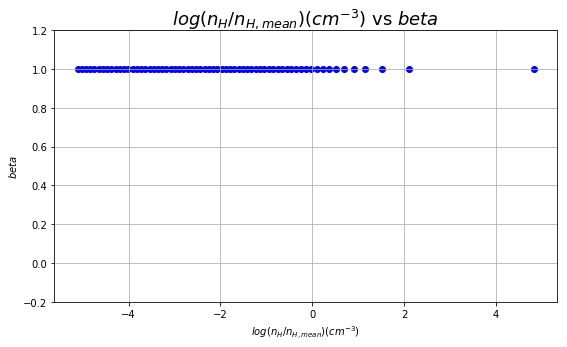

In [12]:
plt.figure(figsize=(9,5))
ax = plt.gca()
plt.scatter(np.log10(n_H_arr/100), beta_nu, c="b")
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
ax.set_ylim([-0.2,1.2])
# ax.set_xlim([-1, 3])
plt.xlabel('$log(n_{H}/n_{H, mean}) (cm^{-3})$')
plt.ylabel('$beta$')
plt.grid(b=True, which='both', axis='both')
plt.title("$log(n_{H}/n_{H, mean}) (cm^{-3})$ vs $beta$")
plt.savefig('radiative_transfer/outputs_RT/1.8/log(n_H)vsbeta.png', 
            dpi=300, bbox_inches='tight')
plt.show()

/net/cephfs/home/mkrets/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


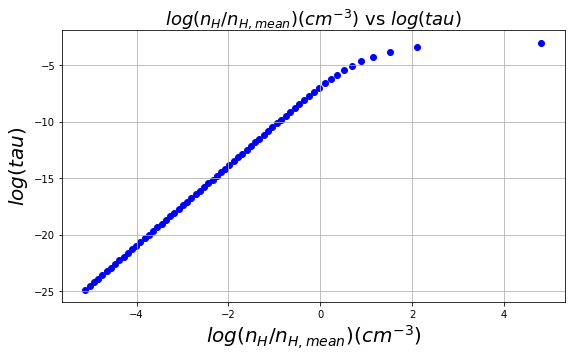

In [13]:
plt.figure(figsize=(9,5))
ax = plt.gca()
plt.scatter(np.log10(n_H_arr/100), np.log10(tau_nu), c="b")
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# ax.set_ylim([-6,1])
# ax.set_xlim([-1, 3])
plt.xlabel('$log(n_{H}/n_{H, mean}) (cm^{-3})$')
plt.ylabel('$log(tau)$')
plt.grid(b=True, which='both', axis='both')
plt.title("$log(n_{H}/n_{H, mean}) (cm^{-3})$ vs $log(tau)$")
plt.savefig('radiative_transfer/outputs_RT/1.8/log(n_H)vslog(tau).png', 
            dpi=300, bbox_inches='tight')
plt.show()

/net/cephfs/home/mkrets/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


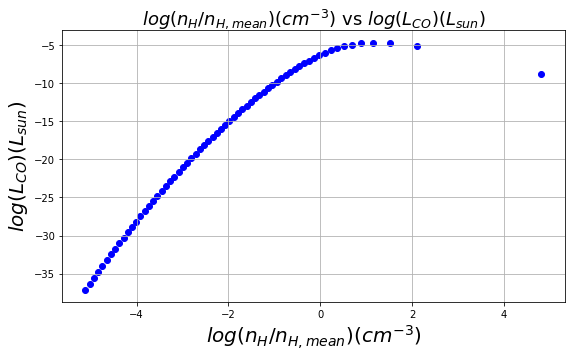

In [14]:
plt.figure(figsize=(9,5))
ax = plt.gca()
plt.scatter(np.log10(n_H_arr/100), np.log10(L_CO), c="b")
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# ax.set_ylim([-6,1])
# ax.set_xlim([-1, 3])
plt.xlabel('$log(n_{H}/n_{H, mean}) (cm^{-3})$')
plt.ylabel('$log(L_{CO})(L_{sun})$')
plt.grid(b=True, which='both', axis='both')
plt.title("$log(n_{H}/n_{H, mean}) (cm^{-3})$ vs $log(L_{CO})(L_{sun})$")
plt.savefig('radiative_transfer/outputs_RT/1.8/log(n_H)vslog(L_CO).png', 
            dpi=300, bbox_inches='tight')
plt.show()

/net/cephfs/home/mkrets/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


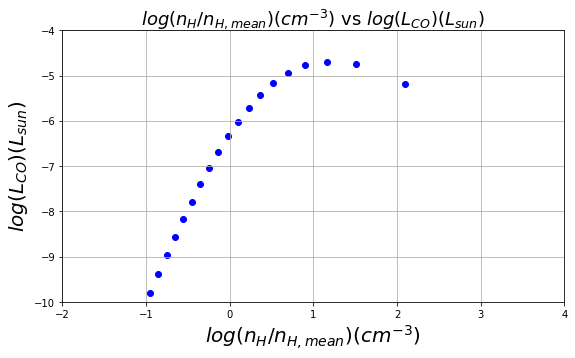

In [15]:
plt.figure(figsize=(9,5))
ax = plt.gca()
plt.scatter(np.log10(n_H_arr/100), np.log10(L_CO), c="b")
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
ax.set_xlim([-2,4])
ax.set_ylim([-10,-4])
plt.xlabel('$log(n_{H}/n_{H, mean}) (cm^{-3})$')
plt.ylabel('$log(L_{CO})(L_{sun})$')
plt.grid(b=True, which='both', axis='both')
plt.title("$log(n_{H}/n_{H, mean}) (cm^{-3})$ vs $log(L_{CO})(L_{sun})$")
plt.savefig('radiative_transfer/outputs_RT/1.8/log(n_H)vslog(L_CO)_comparison.png', 
            dpi=300, bbox_inches='tight')
plt.show()

/net/cephfs/home/mkrets/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


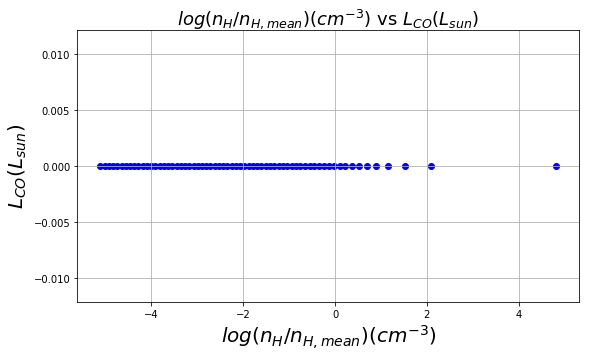

In [16]:
plt.figure(figsize=(9,5))
ax = plt.gca()
plt.scatter(np.log10(n_H_arr/100), L_CO, c="b")
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# ax.set_ylim([-6,1])
# ax.set_xlim([-1, 3])
plt.xlabel('$log(n_{H}/n_{H, mean}) (cm^{-3})$')
plt.ylabel('$L_{CO}(L_{sun})$')
plt.grid(b=True, which='both', axis='both')
plt.title("$log(n_{H}/n_{H, mean}) (cm^{-3})$ vs $L_{CO}(L_{sun})$")
plt.savefig('radiative_transfer/outputs_RT/1.8/log(n_H)vsL_CO.png', 
            dpi=300, bbox_inches='tight')
plt.show()

/net/cephfs/home/mkrets/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


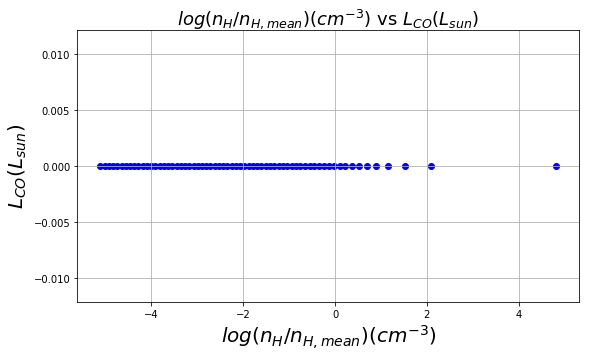

In [17]:
plt.figure(figsize=(9,5))
ax = plt.gca()
plt.scatter(np.log10(n_H_arr/100), L_CO, c="b")
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# ax.set_ylim([-6,1])
# ax.set_xlim([-1, 3])
plt.xlabel('$log(n_{H}/n_{H, mean}) (cm^{-3})$')
plt.ylabel('$L_{CO}(L_{sun})$')
plt.grid(b=True, which='both', axis='both')
plt.title("$log(n_{H}/n_{H, mean}) (cm^{-3})$ vs $L_{CO}(L_{sun})$")
plt.savefig('radiative_transfer/outputs_RT/1.8/log(n_H)vsL_CO.png', 
            dpi=300, bbox_inches='tight')
plt.show()

/net/cephfs/home/mkrets/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


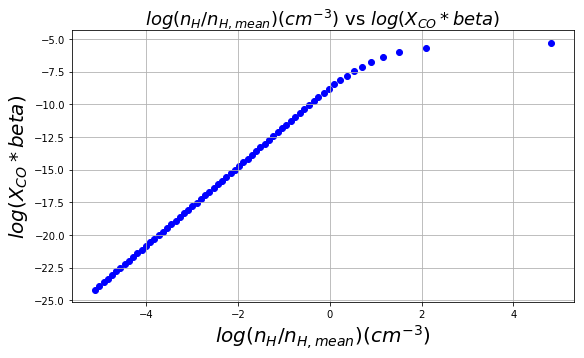

In [18]:
plt.figure(figsize=(9,5))
ax = plt.gca()
plt.scatter(np.log10(n_H_arr/100), np.log10(X_CO_arr*beta_nu), c="b")
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.xlabel('$log(n_{H}/n_{H, mean}) (cm^{-3})$')
plt.ylabel('$log(X_{CO}*beta)$')
plt.title("$log(n_{H}/n_{H, mean}) (cm^{-3})$ vs $log(X_{CO}*beta)$")
plt.grid(b=True, which='both', axis='both')
plt.savefig('radiative_transfer/outputs_RT/1.8/log(n_H)vslog(X_CO*beta).png', 
            dpi=300, bbox_inches='tight')
plt.show()

/net/cephfs/home/mkrets/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


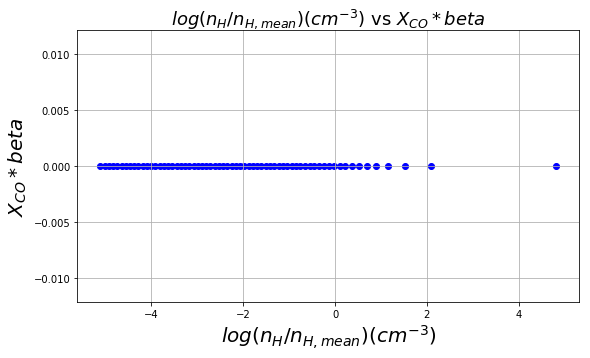

In [19]:
plt.figure(figsize=(9,5))
ax = plt.gca()
plt.scatter(np.log10(n_H_arr/100), X_CO_arr*beta_nu, c="b")
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.xlabel('$log(n_{H}/n_{H, mean}) (cm^{-3})$')
plt.ylabel('$X_{CO}*beta$')
plt.title("$log(n_{H}/n_{H, mean}) (cm^{-3})$ vs $X_{CO}*beta$")
plt.grid(b=True, which='both', axis='both')
plt.savefig('radiative_transfer/outputs_RT/1.8/log(n_H)vsX_CO*beta.png', 
            dpi=300, bbox_inches='tight')
plt.show()

/net/cephfs/home/mkrets/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


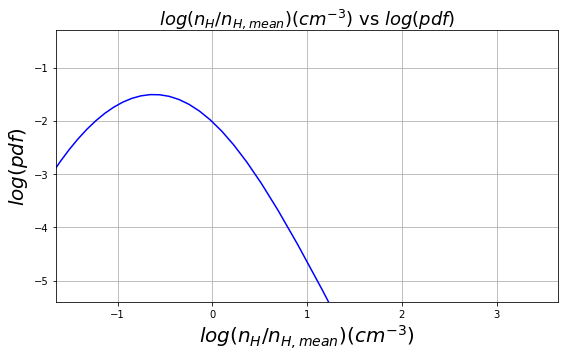

In [20]:
plt.figure(figsize=(9,5))
ax = plt.gca()
plt.plot(np.log10(n_H_arr/100), np.log(pdf_arr), color="b")
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
ax.set_xlim([-1.65,3.65])
ax.set_ylim([-5.4,-0.3])
plt.xlabel('$log(n_{H}/n_{H, mean}) (cm^{-3})$')
plt.ylabel('$log(pdf)$')
plt.grid(b=True, which='both', axis='both')
plt.title("$log(n_{H}/n_{H, mean}) (cm^{-3})$ vs $log(pdf)$")
plt.savefig('radiative_transfer/outputs_RT/1.8/log(n_H)vslog(pdf).png', 
            dpi=300, bbox_inches='tight')
plt.show()